In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math

In [23]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [198]:
image = mpimg.imread('./8.jpg')
height, width = image.shape[0], image.shape[1]

In [199]:
image = cv2.bilateralFilter(image, 5, 10, 10)
# image = cv2.GaussianBlur(image, (3, 3), 1)
low_threshold = 100
high_threshold = 350
canny_edges = cv2.Canny(image,low_threshold,high_threshold)

imshape = image.shape
lower_left = [0, imshape[0]]
lower_right = [imshape[1], imshape[0]]
top_left = [0,imshape[0]/2]
top_right = [imshape[1]/2+imshape[1]/8,imshape[0]/2+imshape[0]/10]

pt1 = [0, height]
pt2 = [width / 2, height / 2]
pt3 = [width / 2, height / 2]
pt4 = [width, height]

# vertices = [np.array([lower_left,top_left,top_right,lower_right],dtype=np.int32)]
vertices = [np.array([pt1,pt2,pt3, pt4],dtype=np.int32)]
roi_image = region_of_interest(image, vertices)


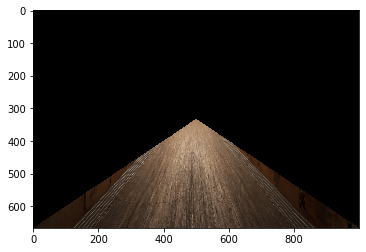

In [200]:
plt.imshow(roi_image)

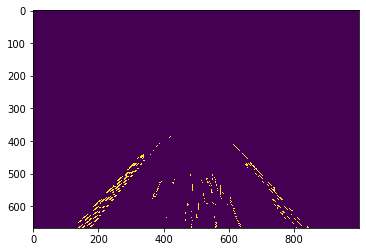

In [201]:
roi_image = region_of_interest(canny_edges, vertices)
plt.imshow(roi_image)

In [202]:
#used below
def get_slope(x1,y1,x2,y2):
    return (y2-y1)/(x2-x1)

def draw_lines(img, lines, color=[255, 0, 0], thickness=3):
    # If there are no lines to draw, exit.
    if lines is None:
        return
    # Make a copy of the original image.
    img = np.copy(img)
    # Create a blank image that matches the original in size.
    line_img = np.zeros(
        (
            img.shape[0],
            img.shape[1],
            3
        ),
        dtype=np.uint8,
    )
    # Loop over all lines and draw them on the blank image.
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(line_img, (x1, y1), (x2, y2), color, thickness)
    # Merge the image with the lines onto the original.
    img = cv2.addWeighted(img, 0.8, line_img, 1.0, 0.0)
    # Return the modified image.
    return img

In [203]:
#rho and theta are the distance and angular resolution of the grid in Hough space
    #same values as quiz
rho = 4
theta = np.pi/180
#threshold is minimum number of intersections in a grid for candidate line to go to output
threshold = 30
min_line_len = 100
max_line_gap = 180
#my hough values started closer to the values in the quiz, but got bumped up considerably for the challenge video

lines = cv2.HoughLinesP(
    roi_image,
    rho=6,
    theta=np.pi / 60,
    threshold=160,
    lines=np.array([]),
    minLineLength=40,
    maxLineGap=25
)

line_image = draw_lines(image, lines)

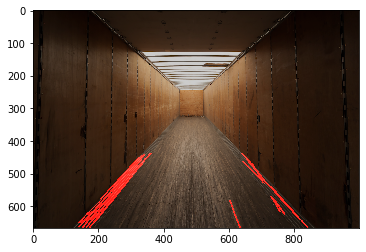

In [204]:
plt.imshow(line_image)

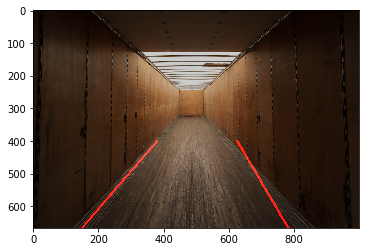

In [205]:
left_line_x = []
left_line_y = []
right_line_x = []
right_line_y = []
for line in lines:
    for x1, y1, x2, y2 in line:
        slope = (y2 - y1) / (x2 - x1) # <-- Calculating the slope.
        if math.fabs(slope) < 0.5: # <-- Only consider extreme slope
            continue
        if slope <= 0: # <-- If the slope is negative, left group.
            left_line_x.extend([x1, x2])
            left_line_y.extend([y1, y2])
        else: # <-- Otherwise, right group.
            right_line_x.extend([x1, x2])
            right_line_y.extend([y1, y2])
min_y = image.shape[0] * (3 / 5) # <-- Just below the horizon
max_y = image.shape[0] # <-- The bottom of the image
poly_left = np.poly1d(np.polyfit(
    left_line_y,
    left_line_x,
    deg=1
))
left_x_start = int(poly_left(max_y))
left_x_end = int(poly_left(min_y))
poly_right = np.poly1d(np.polyfit(
    right_line_y,
    right_line_x,
    deg=1
))
right_x_start = int(poly_right(max_y))
right_x_end = int(poly_right(min_y))
line_image = draw_lines(
    image,
    [[
        [int(left_x_start), int(max_y), int(left_x_end), int(min_y)],
        [int(right_x_start), int(max_y), int(right_x_end), int(min_y)],
    ]],
    thickness=5,
)
plt.figure()
plt.imshow(line_image)
plt.show()